<a href="https://colab.research.google.com/github/jdasam/ant5015/blob/2024F/notebooks/3rd_week_note_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import json
from pathlib import Path

import torch
import torchaudio

In [6]:
'''
Let's only use testset
'''
!wget http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
# !는 주피터에서 터미널 명령어를 사용할때 붙임
# python이 아닌 OS (Linux)에 명령을 내리고 싶을 때 실행


--2024-09-30 09:33:20--  http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|142.250.141.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349501546 (333M) [application/gzip]
Saving to: ‘nsynth-test.jsonwav.tar.gz.1’

nsynth-test.jsonwav 100%[===================>] 333.31M  45.3MB/s    in 8.5s    

2024-09-30 09:33:29 (39.1 MB/s) - ‘nsynth-test.jsonwav.tar.gz.1’ saved [349501546/349501546]



In [7]:
# 압축 풀기
!tar -xf nsynth-test.jsonwav.tar.gz

In [8]:
json_fn = '/content/nsynth-test/examples.json'

with open(json_fn, 'r') as f:
  metadata = json.load(f)

type(metadata)
# , metadata.keys()
metadata['mallet_acoustic_047-106-127']

{'qualities': [0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
 'pitch': 106,
 'note': 174786,
 'instrument_source_str': 'acoustic',
 'velocity': 127,
 'instrument_str': 'mallet_acoustic_047',
 'instrument': 488,
 'sample_rate': 16000,
 'qualities_str': ['fast_decay', 'percussive', 'reverb'],
 'instrument_source': 0,
 'note_str': 'mallet_acoustic_047-106-127',
 'instrument_family': 5,
 'instrument_family_str': 'mallet'}

In [9]:
# list all wav files in dataset
from pathlib import Path
dir = Path('/content/nsynth-test/audio')

dir.exists() # check file or directory exist
# dir.is_file()

# list all wav files in the dir
wav_fns = dir.glob('*.wav')

# for wav in wav_fns:
#   print(wav)

# generator does not save actual list
# print('second loop')
# for wav in wav_fns:
#   print(wav)

wav_fns = list(dir.glob('*.wav'))
wav_fns.sort()
len(wav_fns), len(metadata)
wav_fns[:10]

[PosixPath('/content/nsynth-test/audio/bass_electronic_018-022-100.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-023-025.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-023-075.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-023-127.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-024-025.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-024-100.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-026-025.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-026-075.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-026-127.wav'),
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-027-075.wav')]

In [10]:
wav_fns[0].name, wav_fns[0].stem, wav_fns[0].with_suffix('.pt')

('bass_electronic_018-022-100.wav',
 'bass_electronic_018-022-100',
 PosixPath('/content/nsynth-test/audio/bass_electronic_018-022-100.pt'))

In [11]:
for wav_fn in wav_fns:
  stem = wav_fn.stem
  assert stem in metadata, 'Stem is not in metadata'



In [12]:
import IPython.display as ipd

idx = 1000
wav_fn = wav_fns[idx]

audio_sample, sr = torchaudio.load(wav_fn)
print(audio_sample.shape, sr)

ipd.Audio(audio_sample, rate=sr)

torch.Size([1, 64000]) 16000


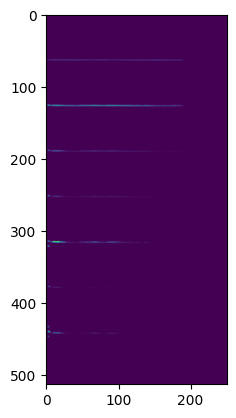

In [13]:
# spectrogram

spec_converter = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=256)
spec = spec_converter(audio_sample)[0] # select 0th item for 0th dim
spec.shape

import matplotlib.pyplot as plt
plt.imshow(spec)

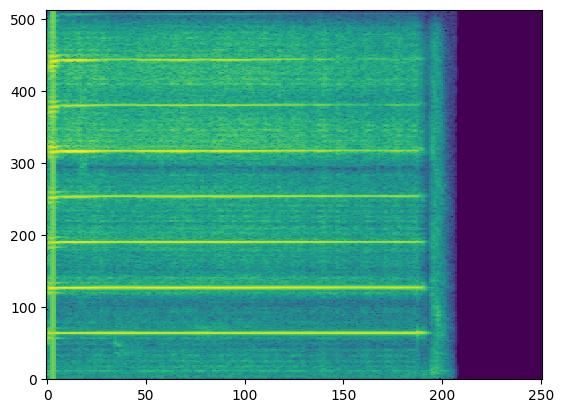

In [14]:
db_converter = torchaudio.transforms.AmplitudeToDB()
db_spec = db_converter(spec)
plt.imshow(db_spec, origin='lower', aspect='auto', interpolation='none')

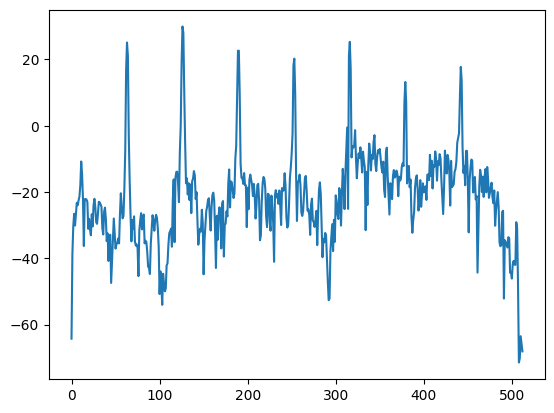

In [15]:
spectrum = db_spec[:, 50]
spectrum.shape
plt.plot(spectrum)

## Make sine wave
- 1 period of angle = 2 * pi
- 220 period of angle = 2 * pi * 220 / sec

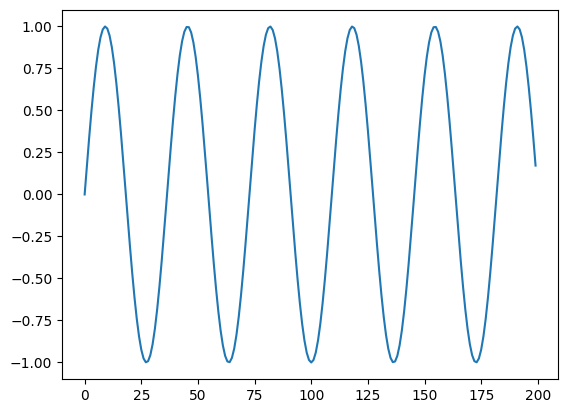

In [16]:
from math import pi
torch.set_printoptions(sci_mode=False)
def make_sine_wav(freq, dur, amp, sr):
  # how many samples do we need?
  num_samples = dur * sr
  output = torch.arange(num_samples)
  # convert to elapsed time in seconds
  output = output / sr # elapsed_time
  # distance = time * speed
  # speed in radian = 2 pi * cycle
  radian_speed = 2 * pi * freq
  output = output * radian_speed # accumulated angle
  output = torch.sin(output) # put it into sin function

  return output

sin = make_sine_wav(freq=440, dur=3, amp=0.5, sr=16000)
ipd.display(ipd.Audio(sin, rate=sr))
plt.plot(sin[:200])

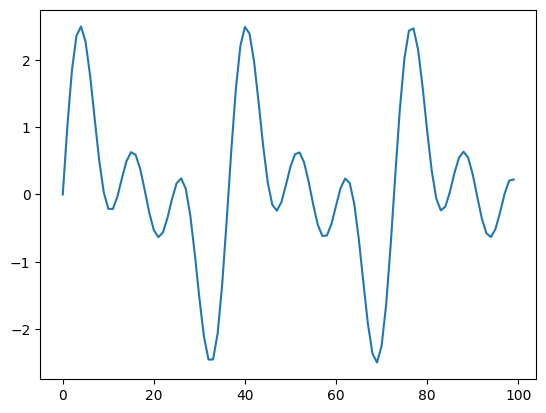

In [17]:
sin = make_sine_wav(freq=440, dur=3, amp=0.5, sr=16000)
sin2 = make_sine_wav(freq=880, dur=3, amp=0.2, sr=16000)
sin3 = make_sine_wav(freq=1320, dur=3, amp=0.05, sr=16000)

merged_sin = sin + sin2 + sin3
ipd.display(ipd.Audio(merged_sin, rate=sr))
plt.plot(merged_sin[:100])

In [18]:
sin = make_sine_wav(freq=440, dur=4, amp=0.5, sr=16000)
audio_with_sin = audio_sample + sin

ipd.Audio(audio_with_sin, rate=sr)

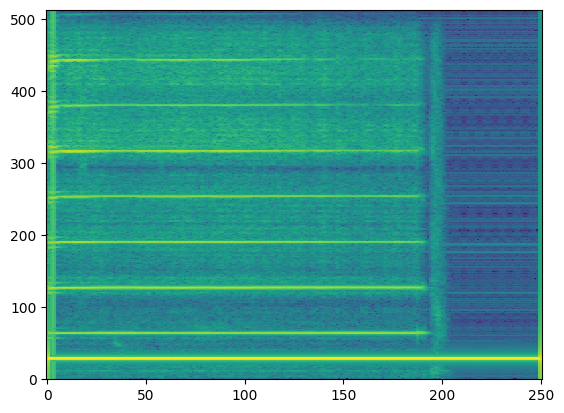

In [19]:
spec = spec_converter(audio_with_sin)
db_spec = db_converter(spec)[0]

plt.imshow(db_spec, origin='lower', aspect='auto', interpolation='none')

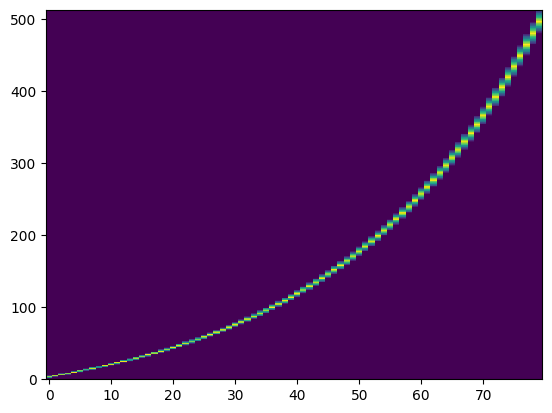

In [20]:
mel_fb = torchaudio.transforms.MelScale(n_mels=80, n_stft=513, sample_rate=sr, f_min=20)
plt.imshow(mel_fb.fb, origin='lower', aspect='auto', interpolation='none')

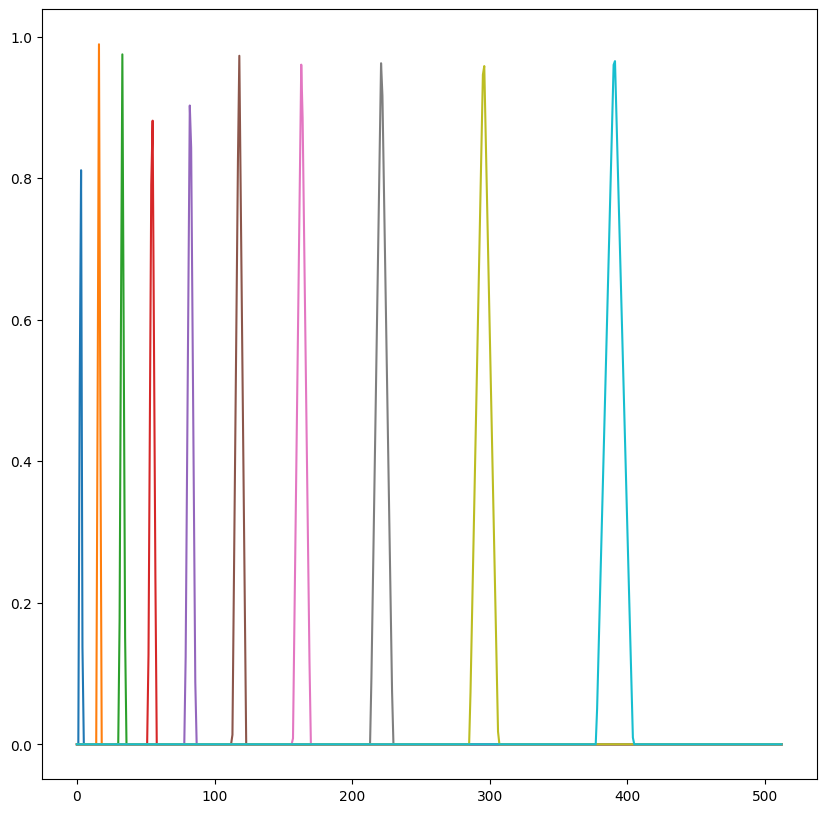

In [21]:
plt.figure(figsize=(10,10))

for i in range(0, 80, 8):
  plt.plot(mel_fb.fb[:, i])

torch.Size([1, 80, 251])


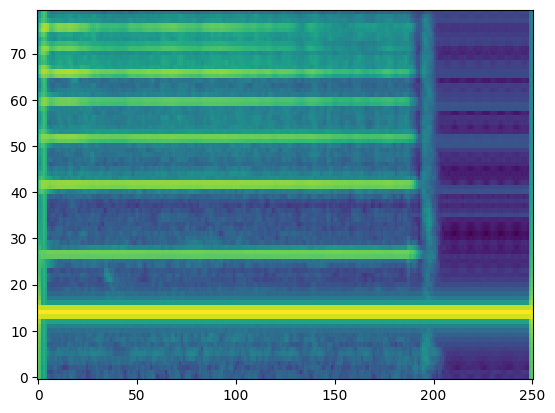

In [22]:
mel_spec = mel_fb(spec)
print(mel_spec.shape)
db_spec = db_converter(mel_spec)[0]
plt.imshow(db_spec, origin='lower', aspect='auto', interpolation='none')

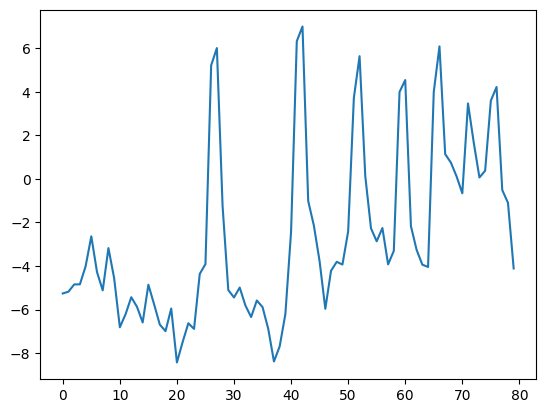

In [23]:
mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                     n_fft=1024,
                                                     hop_length=256,
                                                     f_min=20,
                                                     n_mels=80)
mel_spec = mel_converter(audio_sample[0])
mel_spectrum = mel_spec[:, 30]
plt.plot(mel_spectrum.log())

In [24]:
from tqdm.auto import tqdm
import random
# Load all audio samples and get label

wav_fns.sort()
random.seed(0)
random.shuffle(wav_fns)

spectrums = []
labels = []

for wav_fn in tqdm(wav_fns):
  audio_sample, sr = torchaudio.load(wav_fn)
  db_spectrum = db_converter(mel_converter(audio_sample))[0, :, 30] # 0th channel, every mel bin, 30th time frame
  spectrums.append(db_spectrum)
  pitch = metadata[wav_fn.stem]['pitch'] % 12 # only consider pitch class, ignore octave
  labels.append(pitch)


  0%|          | 0/4096 [00:00<?, ?it/s]

In [25]:
# convert every data sample to torch.tensor
training_data = spectrums[:-100]
training_data = torch.stack(training_data) / 100
training_data.shape,

(torch.Size([3996, 80]),)

In [26]:
training_data.min(), training_data.max()

(tensor(-1.), tensor(0.4712))

In [27]:
training_labels = labels[:-100]
training_labels = torch.tensor(training_labels)
training_labels

tensor([11,  6,  8,  ...,  0, 10, 11])

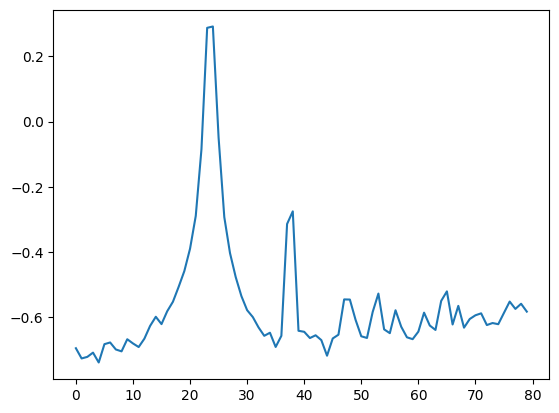

In [34]:
plt.plot(training_data[172, :])

In [28]:
import torch.nn as nn

# classifier takes 80-dim vector (mel-spectrum) and returns 12-dim vector (logit for 12 pitch class)
classifier = nn.Linear(in_features=80, out_features=12)
classifier.weight.shape

torch.Size([12, 80])

In [44]:
# nn.Linear : Wx + b
# W: weight matrix
# b: bias
# x: input

sample_x = training_data[172, :]
sample_weight = torch.randn(80) # gaussian distribution random

# calculate weighted sum

output = []
for i in range(len(sample_x)): # i is index of vector dimension
  x_i = sample_x[i]
  w_i = sample_weight[i]
  weighted_x_i = x_i * w_i
  output.append(weighted_x_i)
weighted_sum = sum(output)
print(weighted_sum)

# use tensor multiplication
weighted_sum = (sample_x * sample_weight).sum()
print(weighted_sum)

# use vector multiplication
weighted_sum = sample_x @ sample_weight
print(weighted_sum)

tensor(0.1590)
tensor(0.1590)
tensor(0.1590)


In [54]:
classifier.weight, classifier.bias
classifier.weight.shape, training_data.shape
# output = training_data * classifier.weight.T #  * means element-wise multiplication
output = torch.mm(training_data, classifier.weight.T)
print(output.shape)
print('bias shape', classifier.bias.unsqueeze(0).shape)
output = output + classifier.bias.unsqueeze(0)

torch.Size([3996, 12])
bias shape torch.Size([1, 12])


In [58]:
logit = classifier(training_data)

torch.allclose(output, logit, atol=1e-8) # check two tensor has almost same value for every item
# (output==logit).all()

True

In [59]:
logit = classifier(training_data)
# logit.shape
logit[300] # logit of 300th sample

tensor([-0.1358, -0.1424,  0.2229,  0.0508, -0.1659,  0.1199, -0.1112, -0.0727,
         0.0164, -0.0432, -0.2067,  0.0630], grad_fn=<SelectBackward0>)

In [30]:
torch.softmax(logit[300], dim=-1)

tensor([0.0747, 0.0742, 0.1069, 0.0900, 0.0724, 0.0964, 0.0765, 0.0795, 0.0869,
        0.0819, 0.0695, 0.0911], grad_fn=<SoftmaxBackward0>)

In [31]:
def softmax(x, dim=-1):
  exp_x = torch.exp(x)
  sum_exp_x = exp_x.sum(dim=dim, keepdim=True)
  return exp_x / sum_exp_x
  print(exp_x)

softmax(logit[300])

tensor([0.0747, 0.0742, 0.1069, 0.0900, 0.0724, 0.0964, 0.0765, 0.0795, 0.0869,
        0.0819, 0.0695, 0.0911], grad_fn=<DivBackward0>)

In [32]:
logit_sum = logit.sum(dim=-1)
print(logit_sum.shape)
logit_sum = logit.sum(dim=-1, keepdim=True)
print(logit_sum.shape)

torch.Size([3996])
torch.Size([3996, 1])


In [63]:
training_labels

tensor([11,  6,  8,  ...,  0, 10, 11])

In [60]:

logit = classifier(training_data)
prob = logit.softmax(dim=-1)


tensor([[0.0983, 0.0939, 0.0481,  ..., 0.0741, 0.0980, 0.1002],
        [0.0995, 0.0903, 0.0471,  ..., 0.0920, 0.0937, 0.0976],
        [0.0993, 0.1307, 0.0462,  ..., 0.0688, 0.1126, 0.0726],
        ...,
        [0.0890, 0.1122, 0.0552,  ..., 0.1036, 0.0740, 0.0835],
        [0.0880, 0.1106, 0.0573,  ..., 0.0876, 0.0999, 0.0849],
        [0.0803, 0.1067, 0.0513,  ..., 0.0858, 0.1058, 0.0903]],
       grad_fn=<SoftmaxBackward0>)

In [64]:
from math import log

log(0.00001)

-11.512925464970229

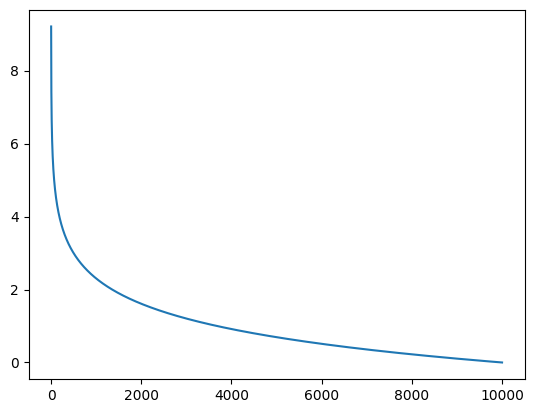

In [67]:
# Calculate loss
# Negative log-likelihood
# nll = -log(x)
# x = 1 -> nll=0
# x = 0.0001 ->

dummy_xs = torch.arange(10000) / 9999
dummy_ys = -torch.log(dummy_xs)
# dummy_ys
plt.plot(dummy_ys)

In [69]:
prob[0], training_labels[0], prob[0, training_labels[0]]


(tensor([0.0983, 0.0939, 0.0481, 0.0671, 0.0730, 0.0842, 0.0625, 0.0579, 0.1428,
         0.0741, 0.0980, 0.1002], grad_fn=<SelectBackward0>),
 tensor(11),
 tensor(0.1002, grad_fn=<SelectBackward0>))

In [70]:
# what torch arange does
torch.arange(len(training_labels))

tensor([   0,    1,    2,  ..., 3993, 3994, 3995])

In [75]:
prob_of_correct_class = prob[torch.arange(len(training_labels)), training_labels]
nll = -torch.log(prob_of_correct_class + 1e-8).mean()
nll

tensor(2.5087, grad_fn=<NegBackward0>)

In [81]:
classifier.weight.grad

tensor([[    -0.0008,     -0.0000,     -0.0001,     -0.0020,     -0.0015,
              0.0023,      0.0044,      0.0007,     -0.0066,     -0.0060,
              0.0008,      0.0071,      0.0038,      0.0027,      0.0054,
             -0.0031,     -0.0110,     -0.0089,      0.0040,      0.0050,
              0.0057,      0.0076,      0.0001,     -0.0004,      0.0065,
              0.0054,      0.0034,     -0.0110,     -0.0140,     -0.0054,
              0.0044,      0.0052,      0.0007,      0.0015,      0.0051,
              0.0023,     -0.0059,     -0.0041,      0.0049,      0.0023,
              0.0008,      0.0027,     -0.0066,     -0.0143,     -0.0094,
              0.0030,      0.0009,      0.0034,     -0.0005,     -0.0024,
              0.0031,      0.0025,      0.0025,     -0.0037,     -0.0030,
              0.0022,      0.0028,      0.0013,     -0.0005,      0.0020,
              0.0006,     -0.0071,     -0.0059,      0.0008,      0.0012,
              0.0008,      0.0014,    

In [89]:
lr = 0.1

# loss_record = []

for i in range(1000):
  logit = classifier(training_data)
  prob = logit.softmax(dim=-1)
  prob_of_correct_class = prob[torch.arange(len(training_labels)), training_labels]
  nll = -torch.log(prob_of_correct_class + 1e-8).mean()

  # backpropgation
  nll.backward() # this generates gradient for model's weights

  # update weight based on gradient
  classifier.weight.data -= classifier.weight.grad * lr
  classifier.bias.data -= classifier.bias.grad * lr

  # reset gradient
  classifier.weight.grad = None
  classifier.bias.grad = None

  loss_record.append(nll.item()) # save only value, not graph


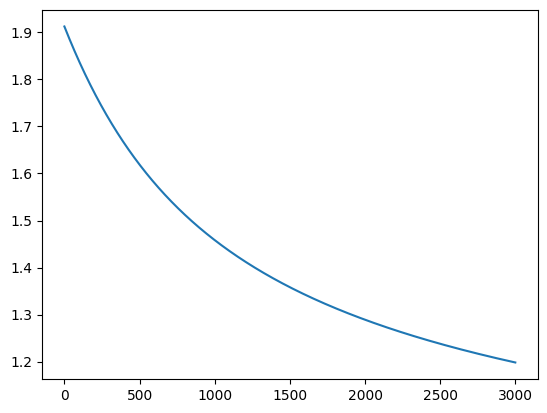

In [90]:
plt.plot(loss_record)

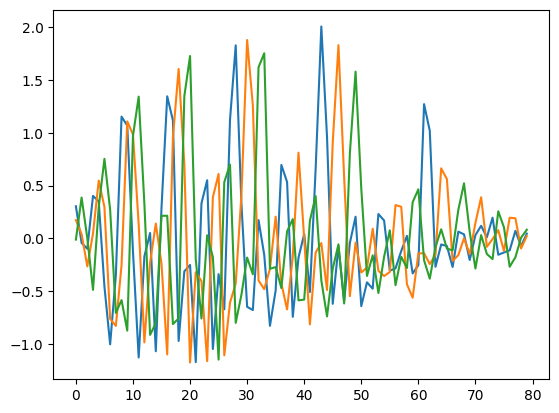

In [97]:
for i in range(0, 6, 2):
  plt.plot(classifier.weight[i].detach())